In [1]:
import pandas as pd
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('D:/wzy/bot/twi22/user.json')[['id', 'location']]
followers = pd.read_csv('followers.csv')
following = pd.read_csv('following.csv')
label = pd.read_csv('twi22/label.csv')

In [3]:
# example: network in topic 3
#tweet = pd.read_csv('topic_tweet1_covid.csv')
#tweet = pd.read_csv('topic_tweet2_war.csv') 
tweet = pd.read_csv('topic_tweet3_climate.csv') 
tweet['uid'] = 'u'+tweet['uid'].astype(str)
select_user_id = set(tweet['uid'])&set(label['id'])
select_user_id = pd.DataFrame({'select_uid': list(select_user_id)})

# 只保留网络中讨论过这个话题的用户
select_followers = pd.merge(followers, select_user_id, left_on='source_id', right_on='select_uid', how='right')
select_followers.dropna(axis=0, inplace=True)
select_followers = pd.merge(select_followers, select_user_id, left_on='target_id', right_on='select_uid', how='right')
select_followers.dropna(axis=0, inplace=True)
select_followers = select_followers[['source_id', 'target_id']]

select_following = pd.merge(following, select_user_id, left_on='source_id', right_on='select_uid', how='right')
select_following.dropna(axis=0, inplace=True)
select_following = pd.merge(select_following, select_user_id, left_on='target_id', right_on='select_uid', how='right')
select_following.dropna(axis=0, inplace=True)
select_following = select_following[['source_id', 'target_id']]
# print(len(select_followers), len(select_following))

# 转化为(2, Num_edges)格式的numpy array, 其中第0行节点follow第1行节点
edges_1 = np.array([select_followers['target_id'].to_list(), select_followers['source_id'].to_list()])
edges_2 = np.array([select_following['source_id'].to_list(), select_following['target_id'].to_list()])
edges = np.concatenate([edges_1, edges_2], axis=1)
print("Check num of edges: ", edges.shape)

# 相应主题下有bot label和relation的uid（用于最终GNN training和effect estimatin）
final_uid = (set(select_user_id['select_uid'])&set(edges[0]))|(set(select_user_id['select_uid'])&set(edges[1]))
print("Num of user selected: ", len(final_uid))

Check num of edges:  (2, 412310)
Num of user selected:  63865


In [4]:
# Using networkx for network data analysis
import networkx as nx
G = nx.DiGraph()
# add the edges (directed)
for e in range(len(edges[0])):
    G.add_edge(edges[0][e], edges[1][e])
print("Num nodes: ", len(G.nodes), "Num edges: ", len(G.edges))

# add the node label (bot or human)
label.set_index('id', inplace=True)
for node_id in G.nodes():
    G.add_nodes_from([(node_id, {'label': label.loc[node_id, 'label']})])
print("Num nodes: ", len(G.nodes), "Num edges: ", len(G.edges))

Num nodes:  63865 Num edges:  407927
Num nodes:  63865 Num edges:  407927


In [5]:
df.set_index('id', inplace=True)
df.head()

,location
id,
u1217628182611927040,"Cambridge, MA"
u2664730894,🎈
u1266703520205549568,None
u1089159225148882949,"Charlottesville, VA"
u36741729,United States


In [6]:
with open('User_location.csv', 'r', encoding='utf-8', errors='ignore') as f:
    location_map1 = pd.read_csv(f)
mapping = dict(zip(location_map1['Original_location'], location_map1['map1']))
df['location_map1'] = df['location'].map(mapping)
print(df.head(20))

                                      location location_map1
id                                                          
u1217628182611927040             Cambridge, MA            UK
u2664730894                                  🎈           NaN
u1266703520205549568                      None           NaN
u1089159225148882949       Charlottesville, VA           USA
u36741729                        United States           USA
u1365527332627247104  Salem, Tamil Nadu, India           NaN
u1679822588                                 🇬🇧           NaN
u1519144464             Umhlanga, South Africa           NaN
u15211869              ÜT: 38.911326,-77.04508           NaN
u1309034737756000256                      None           NaN
u1341789703633178624                      None           NaN
u848975226                                None           NaN
u1109809482656149504                      None           NaN
u138814032                           Argentina     Argentina
u457554412              

In [319]:
df['location_map1'].value_counts()

USA             125038
UK               44071
India            22095
Canada            9479
Global            7500
Germany           6573
Nigeria           6523
France            6377
Australia         5551
Spain             4692
Mexico            4465
South Africa      3954
Kenya             2883
Ireland           2681
Netherlands       2276
Switzerland       2168
Pakistan          2134
Colombia          2115
Iran              1952
Argentina         1911
Brasil            1778
Belgium           1591
Austria           1456
Japan             1325
Italy             1282
Uganda            1280
Singapore         1256
Turkey            1197
Sweden            1191
UAE               1090
Bangladesh        1085
Ghana             1071
Europe            1042
Vague             1035
Egypt              980
Venezuela          852
HK                 825
Chile              759
Brazil             746
New Zealand        650
Metaverse          647
Indonesia          643
Portugal           614
Denmark    

In [70]:
loc_choice = ['UK', 'USA', 'Argentina', 'France', 'Nigeria', 'Germany', 'Iran', 
    'India', 'Global', 'Thailand', 'Indonesia', 'Netherlands',
    'Ireland', 'Kenya', 'Mexico', 'Japan', 'Egypt', 'Canada', 'Spain',
    'South Africa', 'Australia', 'HK', 'Pakistan', 'Denmark', 'China',
    'Uganda', 'Sweden', 'Singapore', 'Switzerland', 'Vague', 'Austria',
    'Europe', 'Tanzania', 'Malaysia', 'Israel', 'Bangladesh', 'Brasil',
    'Turkey', 'Ghana', 'Italy', 'New Zealand', 'Venezuela', 'Colombia',
    'Russia', 'Brazil', 'Belgium', 'Africa', 'UAE', 'Norway', 'Peru',
    'Sri Lanka', 'Metaverse', 'Portugal', 'Finland', 'Philippines',
    'Ukraine', 'Chile', 'Saudi Arabia']

colors_str = ['crimson', 'blue', '#6b6ecf', 'orange', '#637939', 'firebrick', 'green', 
              'yellowgreen', 'powderblue', '#bd9e39', '#e7ba52', 'darkblue', 
              'orangered', '#ad494a', '#d6616b', '#e7969c', '#7b4173', 'lightcoral', 'y', 
              'limegreen', 'teal', '#5254a3', '#6b6ecf', '#9c9ede', '#637939', 
              '#8ca252', '#b5cf6b', '#cedb9c', '#8c6d31', '#bd9e39', 'teal', 
              '#e7cb94', '#843c39', '#ad494a', '#d6616b', '#e7969c', '#7b4173', 
              '#a55194', '#ce6dbd', '#de9ed6', '#1f77b4', '#aec7e8', '#ff7f0e', 
              'stateblue', 'mediumspringgreen', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', 
              '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', 
              '#c7c7c7', '#bcbd22', '#dbdb8d']

print(len(loc_choice), len(colors_str))
# import matplotlib.colors as mcolors
# colors = plt.cm.tab20b.colors + plt.cm.tab20b.colors + plt.cm.tab20.colors
# colors_str = [mcolors.to_hex(c) for c in colors][:58]
# print(colors_str)

color_map = dict(zip(loc_choice, colors_str))

58 58


In [149]:
# ego graph example
def ret_color(node_id):
    location = df.loc[node_id]['location_map1']
    if location not in loc_choice:
        return 'grey'
    return color_map[location]

def draw_graph(sample_user, G_check, is_save, file_path=None):
    ego_graph = nx.ego_graph(G_check, sample_user)

    # 保留有location信息的节点进行绘制
    ego_graph.remove_nodes_from([n for n in ego_graph.nodes if df.loc[n]['location_map1'] not in loc_choice])
    pos = nx.kamada_kawai_layout(ego_graph, center=(0,0))

    nodelist_human = [n for n in ego_graph.nodes() if ego_graph.nodes[n]['label']=='human']
    nodelist_bot = [n for n in ego_graph.nodes() if ego_graph.nodes[n]['label']=='bot']

    plt.figure(figsize=(5,5))
    nx.draw_networkx_nodes(ego_graph, pos, node_size = 50,
            nodelist = nodelist_human,

            node_shape = 'o',
            node_color = [ret_color(c) for c in nodelist_human],
            )

    nx.draw_networkx_nodes(ego_graph, pos, node_size = 50,
            nodelist = nodelist_bot,
            node_shape = 's',
            node_color = [ret_color(c) for c in nodelist_bot],
            )

    nx.draw_networkx_edges(ego_graph, pos)
    if is_save:
        plt.savefig(file_path, dpi=500)
    else:
        plt.show()

In [100]:
G_HfollowingH = G.edge_subgraph([(u,v) for u,v,d in G.edges(data=True) if G.nodes[u]['label']=='human' and G.nodes[v]['label']=='human'])
G_HfollowingB = G.edge_subgraph([(u,v) for u,v,d in G.edges(data=True) if G.nodes[u]['label']=='human' and G.nodes[v]['label']=='bot'])
G_BfollowingH = G.edge_subgraph([(u,v) for u,v,d in G.edges(data=True) if G.nodes[u]['label']=='bot' and G.nodes[v]['label']=='human'])
G_BfollowingB = G.edge_subgraph([(u,v) for u,v,d in G.edges(data=True) if G.nodes[u]['label']=='bot' and G.nodes[v]['label']=='bot'])

In [599]:
# Bot follow human
G_check = G_BfollowingH
i = 0
for node, data in G_check.nodes(data=True):
    location = df.loc[node]['location_map1']
    mark = data['label']
    degree = G_check.degree(node)
    if (mark=='human') or (location!='India') or degree<4:
        continue
    print(node, data, location, color_map[location])
    i+=1
    if i>20:
        break

u40660303 {'label': 'bot'} India yellowgreen
u1346081230744219649 {'label': 'bot'} India yellowgreen
u3171884654 {'label': 'bot'} India yellowgreen
u3670178534 {'label': 'bot'} India yellowgreen
u1265974494629330949 {'label': 'bot'} India yellowgreen
u1124405762 {'label': 'bot'} India yellowgreen
u981473550254198784 {'label': 'bot'} India yellowgreen
u704620080 {'label': 'bot'} India yellowgreen
u1011559160540876800 {'label': 'bot'} India yellowgreen


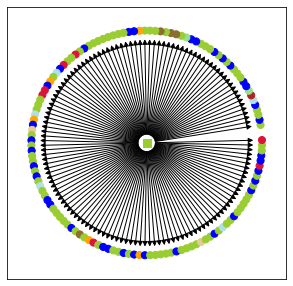

In [612]:
check_node_id = 'u3670178534'
draw_graph(check_node_id, G_check, is_save=True, file_path='img/BfH_India_'+check_node_id+'.png')

In [583]:
# Human follow human
G_check = G_HfollowingH
i = 0
for node, data in G_check.nodes(data=True):
    location = df.loc[node]['location_map1']
    mark = data['label']
    degree = G_check.degree(node)
    if (mark=='bot') or (location!='India') or degree<30:
        continue
    if i>20:
        print(node, data, location, color_map[location])
    i+=1
    if i>40:
        break

u1243467265 {'label': 'human'} India yellowgreen
u1295715136141963267 {'label': 'human'} India yellowgreen
u750375848419602432 {'label': 'human'} India yellowgreen
u17670329 {'label': 'human'} India yellowgreen
u866930936 {'label': 'human'} India yellowgreen
u2485089643 {'label': 'human'} India yellowgreen
u2315152543 {'label': 'human'} India yellowgreen
u1025841643 {'label': 'human'} India yellowgreen
u43855487 {'label': 'human'} India yellowgreen
u108925314 {'label': 'human'} India yellowgreen
u400630125 {'label': 'human'} India yellowgreen
u4682100312 {'label': 'human'} India yellowgreen
u1404741944740257797 {'label': 'human'} India yellowgreen
u3286212547 {'label': 'human'} India yellowgreen
u1310056538 {'label': 'human'} India yellowgreen
u575197302 {'label': 'human'} India yellowgreen
u86478153 {'label': 'human'} India yellowgreen
u287156977 {'label': 'human'} India yellowgreen
u422041712 {'label': 'human'} India yellowgreen
u158451341 {'label': 'human'} India yellowgreen


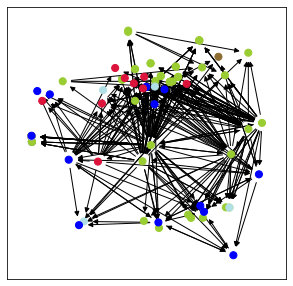

In [587]:
check_node_id = 'u287156977'
draw_graph(check_node_id, G_check, is_save=False, file_path='img/HfH_India_'+check_node_id+'.png')

In [620]:
# Human follow bot
G_check = G_HfollowingB
i = 0
for node, data in G_check.nodes(data=True):
    location = df.loc[node]['location_map1']
    mark = data['label']
    degree = G_check.degree(node)
    if (mark=='bot') or (location!='India') or degree<4:
        continue
    if i>=0:
        print(node, data, location, color_map[location])
    i+=1
    if i>20:
        break

u1042810503238754304 {'label': 'human'} India yellowgreen
u158451341 {'label': 'human'} India yellowgreen
u42938393 {'label': 'human'} India yellowgreen
u1099607376599101441 {'label': 'human'} India yellowgreen
u21821590 {'label': 'human'} India yellowgreen
u4682100312 {'label': 'human'} India yellowgreen
u866930936 {'label': 'human'} India yellowgreen
u795890560884244480 {'label': 'human'} India yellowgreen
u1367168905010053121 {'label': 'human'} India yellowgreen
u2315152543 {'label': 'human'} India yellowgreen
u262641807 {'label': 'human'} India yellowgreen


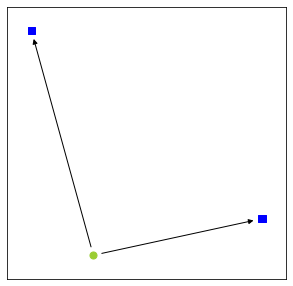

In [630]:
check_node_id = 'u866930936'
draw_graph(check_node_id, G_check, is_save=True, file_path='img/HfB_India_'+check_node_id+'.png')